# **2차 과제 : 데이터 전처리 과정 익히기**

과 목 : 머신러닝

학 번 : 2017250044

이 름 : 정재현

담당 교수님 : 이계식 교수님

# **기본 설정**

In [ ]:
# 파이썬 ≥3.5
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 깔금한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림 저장 위치 지정
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# **데이터 가져오기**

*   온라인 상에 저장된 압출파일 가져오기
*   압축파일을 풀어 csv 파일로 저장

In [ ]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/codingalzi/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "notebooks/datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [ ]:
fetch_housing_data()

*   csv 파일을 판다스 데이터프레임으로 불러오기기

In [ ]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [ ]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


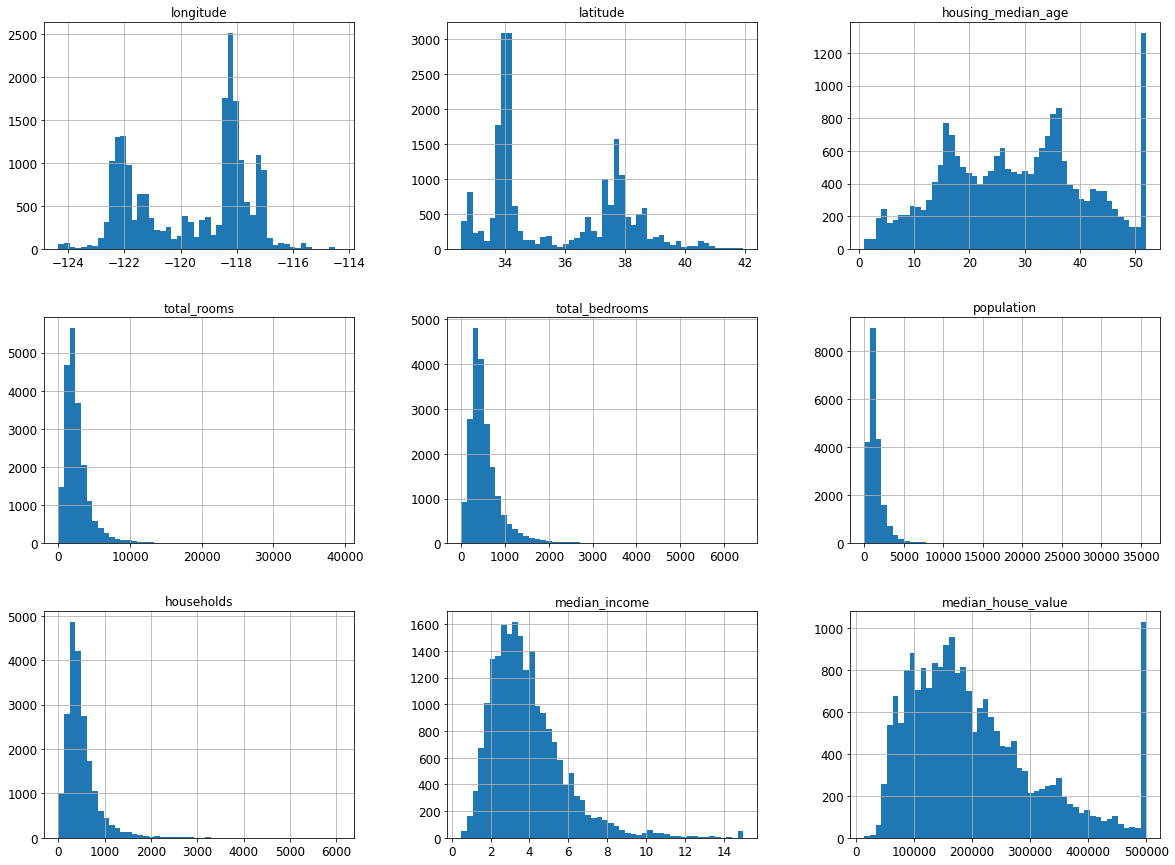

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

##**데이터 세트 만들기**

###**계층적 샘플링**

*   전체 데이터셋의 중간 소득 히스토그램

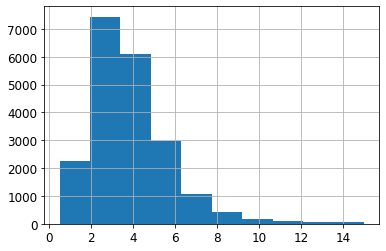

In [ ]:
housing["median_income"].hist()

*   대부분 구역의 중간 소득이 1.5~6.0 사이
*   소득 구간을 아래 숫자를 기준으로 5개로 구분

        [0, 1.5, 3.0, 4.6, 6.0, np,inf]


*   5개의 카테고리를 갖는 특성 추가

    *   특성값 : 1, 2, 3, 4, 5


In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

*   계층(소득 구간) 특성 히스토그램

In [ ]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

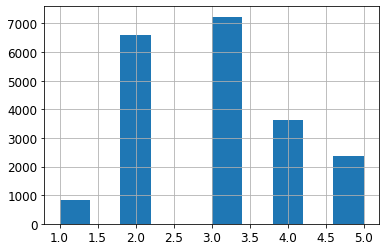

In [ ]:
housing["income_cat"].hist()

*   계층별 샘플링 실행

    *   housing[ " income_cat " ] 기준

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


*   소득 계층 비율이 유지되었음을 확인 가능

In [ ]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [ ]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

* 데이터 되돌리기
    - `income_cat` 특성 삭제
    - 이제 본격적으로 학습 시작할 것임

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# **데이터 이해를 위한 탐색과 시각화**

*   훈련세트 원본을 그대로 두고 복사해서 사용

    *   훈련세트만을 대상으로 탐색과 시각화 적용
    *   데이터 스누핑 편향 방지 용도

In [ ]:
housing = strat_train_set.copy()

###**상관관계 조사**

모든 수치형 특성 간의 표준 상관계수 계산

In [ ]:
corr_matrix = housing.corr()

중간 주택 가격과 다른 특성 간의 상관관계 확인

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

* 피어슨의 상관계수
    * 상관계수: $[-1, 1]$ 구간의 값
    * 1에 가까울 수록: 강한 양의 선형 상관관계
    * -1에 가까울 수록: 강한 음의 선형 상관관계
    * 0에 가까울 수록: 매우 약한 선형 상관관계

![Pearson correlation coefficient](https://upload.wikimedia.org/wikipedia/commons/d/d4/Correlation_examples2.svg)


*   특성들 사이의 상관관계를 나타내는 산점도

그림 저장: scatter_matrix_plot


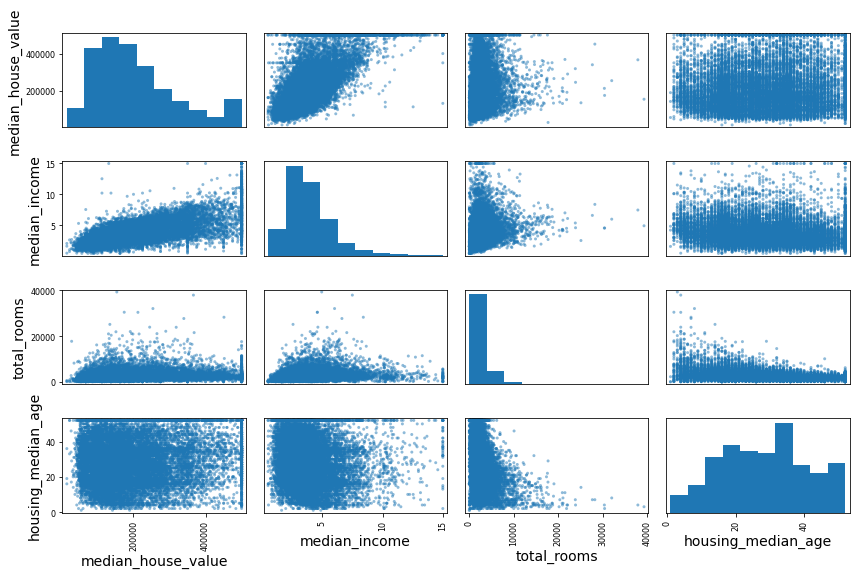

In [ ]:
# from pandas.tools.plotting import scatter_matrix # 옛날 버전의 판다스에서는
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

*   중간 소득 대 중간 주택 가격 산점도

그림 저장: income_vs_house_value_scatterplot


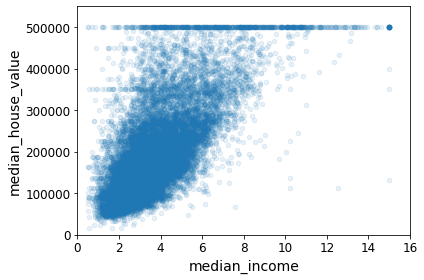

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

*   특징

    *   점들이 너무 넓게 퍼져 있음. 완벽한 선형관계와 거리 멂.
    *   50만 달러 수평선: 가격 제한

        *   35만, 28만, 그 아래 정도에서도 수평선 존재
        *   이상한 형태를 학습하지 않도록 해당 구역을 제거하는 것이 좋음.

**이상치 처리**

아직 이유가 뭔지 모르는 수평선을 이루는 데이터를 어떻게 처리할 것인지 결정해야 한다. 보통 아래 세가지 방식중에 하나를 선택한다. 

###**특성 조합으로 실험**

*   구역별 방의 총 개수와 침실의 총 개수 대신 아래 특성이 보다 유용함

    *   가구당 방의 개수 (rooms for household)
    *   방당 침실 개수 (bedrooms for room)
    *   가구당 인원 (population per household)

In [ ]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64



*   중간 주택 가격과 방 하나당 침실 개수의 연관성 다소 있음
*   가구당 방 개수의 역할은 여전히 미미함



#**머신러닝 알고리즘을 위한 데이터 준비**

In [ ]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


###**데이터 정제**

*   누락된 특성값이 존재 경우, 해당 값 또는 특성을 먼저 처리해야 함
*   total_bedrooms 특성에 207개 구역에 대한 값이 null로 채워져 있음, 즉, 일부 구역에 대한 정보가 누락됨.

In [ ]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,175000.0,<1H OCEAN,2.571135,NaN,2.254446
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,264400.0,<1H OCEAN,6.371389,NaN,4.178817
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,287100.0,<1H OCEAN,5.064767,NaN,2.588083
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,95800.0,INLAND,5.511509,NaN,2.657289
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,191000.0,<1H OCEAN,4.866192,NaN,2.468327


*   옵션 1 : 해당 구역 제거

In [ ]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # 옵션 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household



*   옵션 2 : 전체 특성 삭제

In [ ]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # 옵션 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,175000.0,<1H OCEAN,2.571135,NaN,2.254446
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,264400.0,<1H OCEAN,6.371389,NaN,4.178817
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,287100.0,<1H OCEAN,5.064767,NaN,2.588083
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,95800.0,INLAND,5.511509,NaN,2.657289
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,191000.0,<1H OCEAN,4.866192,NaN,2.468327


In [ ]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # 옵션 3

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

중간값이 수치형 특성에서만 계산될 수 있기 때문에 텍스트 특성을 삭제합니다:

In [ ]:
housing_num = housing.drop("ocean_proximity", axis=1)
# 다른 방법: housing_num = housing.select_dtypes(include=[np.number])

In [ ]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [ ]:
imputer.statistics_

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.11950000e+03,
        4.33000000e+02,  1.16400000e+03,  4.08000000e+02,  3.54090000e+00,
        1.79500000e+05,  5.23228423e+00,  2.03031374e-01,  2.81765270e+00])

각 특성의 중간 값이 수동으로 계산한 것과 같은지 확인해 보세요:

In [ ]:
housing_num.median().values

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.11950000e+03,
        4.33000000e+02,  1.16400000e+03,  4.08000000e+02,  3.54090000e+00,
        1.79500000e+05,  5.23228423e+00,  2.03031374e-01,  2.81765270e+00])

훈련 세트를 변환합니다:

In [ ]:
X = imputer.transform(housing_num)

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [ ]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,175000.0,2.571135,0.203031,2.254446
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,264400.0,6.371389,0.203031,4.178817
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,287100.0,5.064767,0.203031,2.588083
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,95800.0,5.511509,0.203031,2.657289
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,191000.0,4.866192,0.203031,2.468327


###**텍스트와 범주형 특성 다루기**

이제 범주형 입력 특성인 ocean_proximity을 전처리합니다:

In [ ]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [ ]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

**텍스트와 범주형 특성 다루기 : 원-핫 인코딩**

*   범주형 특성인 해안 근접도(ocean_proximity)를 수치형 데이터로 변환해야 함
*   단순 수치화 적용 가능



**단순 수치화의 문제점**

*   해안 근접도는 단순히 구분을 위해 사용. 해안에 근접하고 있다 해서 주택 가격이 기본적으로 더 비싸지 않음.
*   반면에 수치화된 값들은 크기를 비교할 수 있는 숫자
*   따라서 모델 학습 과정에서 숫자들의 크기 때문에 잘못된 학습이 이루어질 수 있음.

**원-핫 인코딩**

*   수치화된 범주들 사이의 크기 비교를 피하기 위해 더미(dummy) 특성을 추가하여 활용

    *   범주 수 만큼의 더미 특성 추가

*   예를 들어, 해안 근접도 특성 대신에 다섯 개의 범주 전부를 새로운 특성으로 추가한 후 각각의 특성값을 아래처럼 지정
    *   해당 카테고리의 특성값: 1
    *   나머지 카테고리의 특성값: 0

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

OneHotEncoder는 기본적으로 희소 행렬을 반환합니다. 필요하면 toarray() 메서드를 사용해 밀집 배열로 변환할 수 있습니다:

In [ ]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

또는 OneHotEncoder를 만들 때 sparse=False로 지정할 수 있습니다:

**OneHotEncoder 변환기**

*   sparse 키워드 인자

    *   기본값은 True.
    *   1의 위치만 기억하는 희소 행렬로 처리. 대용량 행렬 처리에 효과적임.
    *   False로 지정할 경우 일반 행렬로 처리.



In [ ]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

###**나만의 변환기**

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# 열 인덱스
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # *args 또는 **kargs 없음
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # 아무것도 하지 않습니다
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.to_numpy())

책에서는 간단하게 인덱스 (3, 4, 5, 6)을 하드코딩했지만 다음처럼 동적으로 처리하는 것이 더 좋습니다:

In [ ]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # 열 인덱스 구하기

또한 housing_extra_attribs는 넘파이 배열이기 때문에 열 이름이 없습니다(안타깝지만 사이킷런을 사용할 때 생기는 문제입니다). DataFrame으로 복원하려면 다음과 같이 할 수 있습니다:

In [ ]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,286600,<1H OCEAN,4.62537,0.223852,2.0944,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,340600,<1H OCEAN,6.00885,0.159057,2.70796,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,196900,NEAR OCEAN,4.22511,0.241291,2.02597,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,46300,INLAND,5.23229,0.200866,4.13598,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,254500,<1H OCEAN,4.50581,0.231341,3.04785,4.50581,3.04785


###**변환 파이프라인**

수치형 특성을 전처리하기 위해 파이프라인을 만듭니다:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [ ]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [ ]:
housing_prepared.shape

(16512, 20)

다음은 (판다스 DataFrame 열의 일부를 선택하기 위해) DataFrameSelector 변환기와 FeatureUnion를 사용한 예전 방식입니다

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# 수치형 열과 범주형 열을 선택하기 위한 클래스
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

하나의 큰 파이프라인에 이들을 모두 결합하여 수치형과 범주형 특성을 전처리합니다:

In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [ ]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [ ]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

ColumnTransformer의 결과와 동일합니다:

In [ ]:
np.allclose(housing_prepared, old_housing_prepared)

True

# **모델 선택과 훈련**




*   목표 달성에 필요한 두 요소를 결정해야 함

    *   학습 모델
    *   회귀 모델 성능 측정 지표

*   목표 : 구역별 중간 주택 가격 예측 모델
*   학습 모델 : 회귀 모델
*   회귀 모델 성능 측정 지표 : 평균 제곱근 오차(RMSE)

###**훈련 세트에서 훈련하고 평가하기**

할 일 : 
*   예측기 모델 선택 후 훈련시키기
*   예제 : 선형 회귀, 결정트리 회귀

예측기 모델 선택 후 훈련과정은 매우 단순함.

*   fit() 메서드를 전처리 처리가 된 훈련 데이터셋에 적용

**선형 회귀 모델**
*   사이킷런의 LinearRegression 클래스 활용

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# 훈련 샘플 몇 개를 사용해 전체 파이프라인을 적용해 보겠습니다
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("예측:", lin_reg.predict(some_data_prepared))

예측: [286600. 340600. 196900.  46300. 254500.]


실제 값과 비교한다.

In [ ]:
print("레이블:", list(some_labels))

레이블: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [ ]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744,  0.68806755, -0.31205452,
         0.19380531, -0.08649871, -0.31205452, -0.08649871,  0.15531753,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  1.15479381,  0.21768338,
        -0.94074539, -0.03353391,  0.21768338, -0.03353391, -0.83628902,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.08721662, -0.46531516,
         0.49916044, -0.09240499, -0.46531516, -0.09240499,  0.4222004 ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -

In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

2.0651503025399122e-10

RMSE(평균 제곱근 오차)가 68628.198 정도로 별로 좋지 않음.

훈련된 모델이 훈련 세트에 과소적합 됨

*   보다 좋은 특정을 찾거나 더 강력한 모델을 적용해야 함
*   보다 좋은 특성 예제 : 로그 함수를 적용한 인구수 등 





**결정트리 회귀 모델**

*   결정트리 회귀 모델 생성: 사이킷런의 DecisionTreeRegressor 클래스 활용
*   훈련 및 예측

    *   예측은 훈련 세트에 포함된 몇 개 데이터를 대상으로 예측 실행




In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

*   RMSE(평균 제곱근 오차)가 0으로 완벽해 보임.
*   훈련된 모델이 훈련 세트에 심각하게 과대적합 됨.

    *   실전 상황에서 RMSE가 0이 되는 것은 불가능.
    *   훈련 세트가 아닌 테스트 세트에 적용할 경우 RMSE가 크게 나올 것임.

#**프로젝트 과제**

아래의 세 가지 변환을 전처리 과정에 추가하면 훈련된 모델의 성능이 어떻게 얼마나 달라지는지 이전 모델과 비교하라.

__변환 1__

중간 소득과 중간 주택 가격 사이의 상관관계 그래프에서 확인할 수 있는 수평선에 위치한 데이터를 삭제한다.

__변환 2__

회귀 모델 훈련에 사용되는 12개의 특성 중에 세 개는 기존 9개의 특성을 조합하여 생성하였다. 12개의 특성 중에 중간 주택 가격과의 상관계수의 절댓값이 0.2 보다 작은 특성을 삭제한다.

__변환 3__

범주형 특성을 제외한 9개 특성별 히스토그램을 보면 일부 특성의 히스토그램이 좌우 비대칭이다. 
(전문 용어로 __왜도__(skewness)가 0이 아닐 때 이런 분포가 발생한다.)
대표적으로 방의 총 개수(total_rooms), 침실 총 개수(total_bedrooms), 인구(population), 가구수(households), 중간소득(median_income) 등 다섯 개의 특성이 그렇다.
앞서 언급된 5개 특성 또는 일부에 대해 __로그 변환__을 적용한다.

#**변환 1**

In [ ]:
housing[housing["median_house_value"]>250000]["median_house_value"].value_counts().head(10)

500001.0    786
350000.0     65
275000.0     46
450000.0     28
300000.0     23
500000.0     23
400000.0     19
262500.0     19
258300.0     18
325000.0     16
Name: median_house_value, dtype: int64

In [ ]:
housing_test = housing.drop(housing[housing["median_house_value"] == 500001].index)

In [ ]:
housing_test = housing_test.drop(housing[housing["median_house_value"] == 350000].index)

In [ ]:
housing_test = housing_test.drop(housing[housing["median_house_value"] == 275000].index)

그림 저장: income_vs_house_value_scatterplot


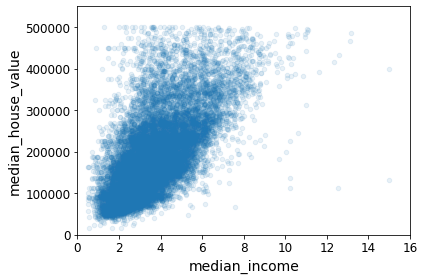

In [ ]:
housing_test.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

#**변환 2**



In [ ]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [ ]:
housing_test["rooms_per_household"] = housing_test["total_rooms"]/housing_test["households"]
housing_test["bedrooms_per_room"] = housing_test["total_bedrooms"]/housing_test["total_rooms"]
housing_test["population_per_household"]=housing_test["population"]/housing_test["households"]

In [ ]:
corr_matrix = housing_test.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.648879
total_rooms                 0.149185
rooms_per_household         0.109404
households                  0.098549
total_bedrooms              0.077124
housing_median_age          0.071851
population                  0.014172
population_per_household   -0.025260
longitude                  -0.041849
latitude                   -0.151706
bedrooms_per_room          -0.237755
Name: median_house_value, dtype: float64

12개의 특성 중에 중간 주택 가격과의 상관계수의 절댓값이 0.2 보다 작은 특성을 삭제한다.

In [ ]:
housing_test.drop(['total_rooms', 'rooms_per_household', 'rooms_per_household', 'households', 'total_bedrooms', 'housing_median_age', 'population', 'population_per_household', 'longitude', 'latitude'], axis=1, inplace=True)

In [ ]:
housing_test

,median_income,median_house_value,ocean_proximity,bedrooms_per_room
17606,2.7042,286600.0,<1H OCEAN,0.223852
18632,6.4214,340600.0,<1H OCEAN,0.159057
14650,2.8621,196900.0,NEAR OCEAN,0.241291
3230,1.8839,46300.0,INLAND,0.200866
3555,3.0347,254500.0,<1H OCEAN,0.231341
...,...,...,...,...
7364,1.8897,174300.0,<1H OCEAN,0.256970
6563,4.9312,240200.0,INLAND,0.185681
12053,2.0682,113000.0,INLAND,0.245819
13908,3.2723,97800.0,INLAND,0.179609


# **변환 3**

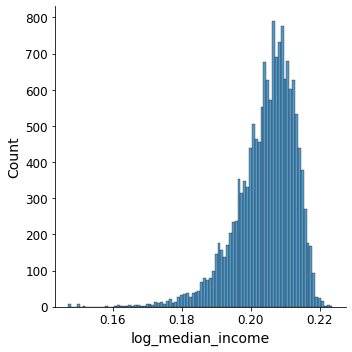

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

housing_test["log_median_income"] = np.log1p(housing_test["median_income"])
sns.displot(housing_test["log_median_income"])
plt.show()

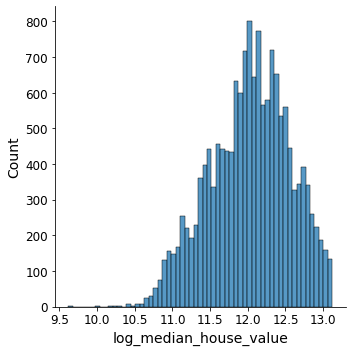

In [ ]:
housing_test["log_median_house_value"] = np.log1p(housing_test["median_house_value"])
sns.displot(housing_test["log_median_house_value"])
plt.show()

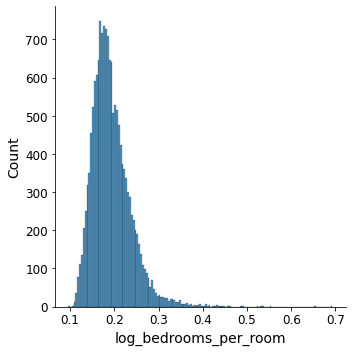

In [ ]:
housing_test["log_bedrooms_per_room"] = np.log1p(housing_test["bedrooms_per_room"])
sns.displot(housing_test["log_bedrooms_per_room"])
plt.show()

In [7]:
n = int(input("n:"))
i = n
result1 = []
result2 = []
result3 = []

while n:
    result1.append(int(input("list number:")))
    n = n-1

print(result1)

while i:
    result2.append(result1)
    a = result1.pop(0)
    result1.append(a)

    i = i-1
print(result2)

n:4
list number:1
list number:4
list number:6
list number:9
[1, 4, 6, 9]
[[1, 4, 6, 9], [1, 4, 6, 9], [1, 4, 6, 9], [1, 4, 6, 9]]
